In [38]:
import matplotlib.pyplot as plt
import random
from visualizer.main import Visualizer

GEN_POINT_NUMBER = 64
QT_NODE_CAPACITY = 4

In [63]:
# Axis-aligned bounding box with half dimension and center
class AABB:
    def __init__(self, center: tuple[float, float], half_width: float, half_height: float):
        """
        Initialize an axis-aligned bounding box (AABB).
        
        :param center: The center point of the rectangle.
        :param width: The width of the rectangle.
        :param height: The height of the rectangle.
        """
        self.center = center
        self.half_width = half_width
        self.half_height = half_height

    def contains_point(self, point: tuple[float, float]) -> bool:
        """
        Check if a point is within the bounds of the rectangle

        :param point: The point to check.
        :return: True if the point is within the bounds, otherwise False.
        """
        x_valid = self.center[0] - self.half_width <= point[0] <= self.center[0] + self.half_width
        y_valid = self.center[1] - self.half_height <= point[1] <= self.center[1] + self.half_height

        return x_valid and y_valid

    def intersects_AABB(self, other: 'AABB') -> bool:
        """
        Check if this AABB intersects with another AABB. Two AABBs intersect
        if their projections on both axes overlap.

        :param other: The other AABB to check for intersection.
        :return: True if the AABBs intersect, otherwise False.
        """
        # Calculate the distance between centers
        dx = abs(other.center[0] - self.center[0])
        dy = abs(other.center[1] - self.center[1])

        # Check overlap on x-axis and y-axis
        overlap_x = dx <= (self.half_width + other.half_width)
        overlap_y = dy <= (self.half_height + other.half_height)

        # If both axes overlap, the rectangles intersect
        return overlap_x and overlap_y


# QuadTree class
# This class represents both one quad tree and the node where it is rooted.
class QuadTree:
    def __init__(self, boundary: AABB, capacity: int = QT_NODE_CAPACITY):
        # constant, how many elements can be stored in node
        self.qt_node_capacity = capacity

        # represent boundary of this quad tree
        self.boundary = boundary

        # points that this quadTree holds, len(points) <= self.qt_node_capacity
        self.points = []
        
        # Childs of this QuadTree Node, they are of type QuadTree
        self.north_west = None
        self.north_east = None
        self.south_west = None
        self.south_east = None
 
    
    def insert(self, point: tuple[float, float]) -> None:
        contains_point = self.boundary.contains_point(point)

        if not contains_point:
            #print(self.boundary.center[0], self.boundary.center[1], self.boundary.half_width, self.boundary.half_height, " not contains point: ", point[0], point[1])
            return

        # We hvaen't created children yet and can still put points inside a box
        if self.north_west is None and len(self.points) < self.qt_node_capacity:
            #print("Inserted", point[0], point[1], "into square: ", self.boundary.center[0], self.boundary.center[1])
            self.points.append(point)
        # if in point is in range, but we have too much inside current node
        else:
            if self.north_west is None:
                self.subdivide()

            self.north_west.insert(point)
            self.north_east.insert(point)
            self.south_west.insert(point)
            self.south_east.insert(point)
 
    def subdivide(self) -> None:
        """
        Create 4 children that fully divide this quad into four quads of equal area
        """
        print(self.boundary.center)
        q_width = self.boundary.half_width / 2
        q_height = self.boundary.half_height / 2

        # Create child AABBs
        self.north_west = QuadTree(
            AABB((self.boundary.center[0] - q_width, self.boundary.center[1] - q_height), q_width, q_height)
        )
        self.north_east = QuadTree(
            AABB((self.boundary.center[0] + q_width, self.boundary.center[1] - q_height), q_width, q_height)
        )
        self.south_west = QuadTree(
            AABB((self.boundary.center[0] - q_width, self.boundary.center[1] + q_height), q_width, q_height)
        )
        self.south_east = QuadTree(
            AABB((self.boundary.center[0] + q_width, self.boundary.center[1] + q_height), q_width, q_height)
        )

        #print(f"SUBDIVIDE_ID: {id}, parent: {self}")
        # Split all points of current quadtree to all of its children
        for point in self.points:

            self.north_west.insert(point)
            self.north_east.insert(point)
            self.south_west.insert(point)
            self.south_east.insert(point)
                
        # TODO: jk: check if there should be .clear instead of new list assignment
        self.points = []

    def query_range(self, box: AABB) -> list[tuple[float, float]]:
        """
        Find all points that appear within a box
        """
        # Using set will handle cases when point lies on AABB border. In list we would classify it as 2 different points
        points_in_range = []

        # if we ranges don't intersect we don't have a match and return empty list
        if not self.boundary.intersects_AABB(box):
            return points_in_range

        for point in self.points:
            if box.contains_point(point):
                points_in_range.append(point)

        # We don't have any child nodes, then return        
        if self.north_west is None:
            return points_in_range

        # add all points from children that are within range
        for child in [self.north_west, self.north_east, self.south_west, self.south_east]:
            for point in child.query_range(box):
                points_in_range.append(point)

        return points_in_range


def BuildQuadTree(boundary: AABB, node_capacity: int, points: list[tuple[float, float]]) -> QuadTree:
    qtree = QuadTree(boundary, capacity=node_capacity)

    for point in points:
        qtree.insert(point)

    return qtree


# Random points generator
def generate_random_points(num_points, range_min, range_max):
    return [(random.uniform(range_min, range_max), random.uniform(range_min, range_max)) for _ in range(num_points)]


def get_points(node: QuadTree, points):
    for p in node.points:
        #print(p[0], p[1])
        points.append(p)
    for child in [node.north_west, node.north_east, node.south_west, node.south_east]:
        if child:
            get_points(child, points)

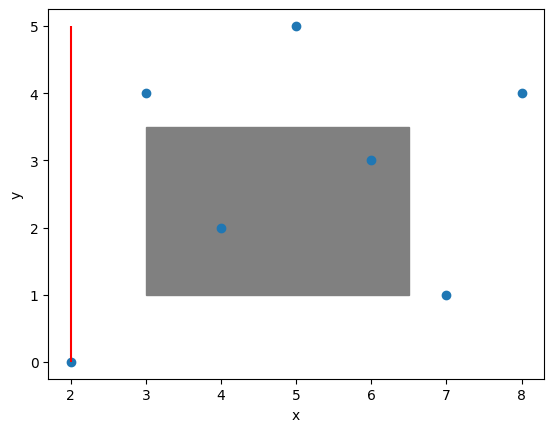

In [64]:
points = [(5,5), (3,4), (6,3), (4,2), (2,0), (7,1), (8,4)]
line=[[(2,0),(2,5)]]
polygon=[(3,1),(3,3.5),(6.5,3.5),(6.5,1)]
vis = Visualizer()
vis.add_polygon(polygon, fill=True, color='grey')

vis.add_point(points)
vis.add_line_segment(line, color='red')
vis.show()

In [106]:
# QuadTree class
# This class represents both one quad tree and the node where it is rooted.
class QuadTreeVisualize:
    def __init__(self, boundary: AABB, vis: Visualizer, capacity: int = QT_NODE_CAPACITY):
        # constant, how many elements can be stored in node
        self.qt_node_capacity = capacity

        # represent boundary of this quad tree
        self.boundary = boundary

        # points that this quadTree holds, len(points) <= self.qt_node_capacity
        self.points = []
        
        # Childs of this QuadTree Node, they are of type QuadTree
        self.north_west = None
        self.north_east = None
        self.south_west = None
        self.south_east = None

        self.vis = vis
    
    def insert(self, point: tuple[float, float]) -> None:
        contains_point = self.boundary.contains_point(point)

        if not contains_point:
            #print(self.boundary.center[0], self.boundary.center[1], self.boundary.half_width, self.boundary.half_height, " not contains point: ", point[0], point[1])
            return

        # We hvaen't created children yet and can still put points inside a box
        if self.north_west is None and len(self.points) < self.qt_node_capacity:
            #print("Inserted", point[0], point[1], "into square: ", self.boundary.center[0], self.boundary.center[1])
            self.points.append(point)
        # if in point is in range, but we have too much inside current node
        else:
            if self.north_west is None:
                self.subdivide()

            self.north_west.insert(point)
            self.north_east.insert(point)
            self.south_west.insert(point)
            self.south_east.insert(point)
 
    def subdivide(self) -> None:
        """
        Create 4 children that fully divide this quad into four quads of equal area
        """
        q_width = self.boundary.half_width / 2
        q_height = self.boundary.half_height / 2
        #line=[[(2,0),(2,5)]]
        
        # Create child AABBs
        self.north_west = QuadTreeVisualize(
            AABB((self.boundary.center[0] - q_width, self.boundary.center[1] - q_height), q_width, q_height), self.vis
        )        
        self.north_east = QuadTreeVisualize(
            AABB((self.boundary.center[0] + q_width, self.boundary.center[1] - q_height), q_width, q_height), self.vis
        )        
        self.south_west = QuadTreeVisualize(
            AABB((self.boundary.center[0] - q_width, self.boundary.center[1] + q_height), q_width, q_height), self.vis
        )
        self.south_east = QuadTreeVisualize(
            AABB((self.boundary.center[0] + q_width, self.boundary.center[1] + q_height), q_width, q_height), self.vis
        )

        # Add new boxes lines to vis
        self.vis.add_line_segment([
            [
                (self.boundary.center[0] - self.boundary.half_width, self.boundary.center[1]),
                (self.boundary.center[0], self.boundary.center[1])
            ],
            [
                (self.boundary.center[0], self.boundary.center[1] - self.boundary.half_height),
                (self.boundary.center[0], self.boundary.center[1])
            ],
            [
                (self.boundary.center[0] + self.boundary.half_width, self.boundary.center[1]),
                (self.boundary.center[0], self.boundary.center[1])
            ],
            [
                (self.boundary.center[0], self.boundary.center[1] + self.boundary.half_height),
                (self.boundary.center[0], self.boundary.center[1])
            ]
        ], color="red")
        
        # Split all points of current quadtree to all of its children
        for point in self.points:
            self.north_west.insert(point)
            self.north_east.insert(point)
            self.south_west.insert(point)
            self.south_east.insert(point)
                
        # TODO: jk: check if there should be .clear instead of new list assignment
        self.points = []

    def query_range(self, box: AABB) -> list[tuple[float, float]]:
        """
        Find all points that appear within a box
        """
        # Using set will handle cases when point lies on AABB border. In list we would classify it as 2 different points
        points_in_range = []

        # if we ranges don't intersect we don't have a match and return empty list
        if not self.boundary.intersects_AABB(box):
            return points_in_range

        for point in self.points:
            if box.contains_point(point):
                points_in_range.append(point)

        # We don't have any child nodes, then return        
        if self.north_west is None:
            return points_in_range

        # add all points from children that are within range
        for child in [self.north_west, self.north_east, self.south_west, self.south_east]:
            for point in child.query_range(box):
                points_in_range.append(point)

        return points_in_range


In [107]:
def build_quadtree_vis(boundary: AABB, points: list[tuple[float, float]], vis: Visualizer):
    vis.add_point(points, color="orange")
    
    qtree = QuadTreeVisualize(boundary, vis)
    for point in points:
        qtree.insert(point)

    return qtree

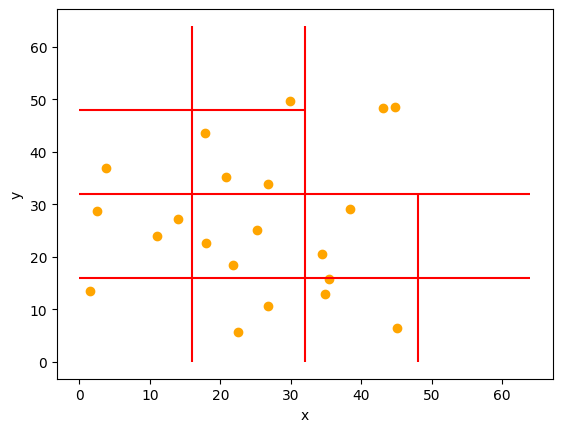

In [108]:
vis = Visualizer()
points = generate_random_points(21, 0, 50)
qtree = build_quadtree_vis(AABB((32, 32), 32, 32), points, vis)
vis.show()

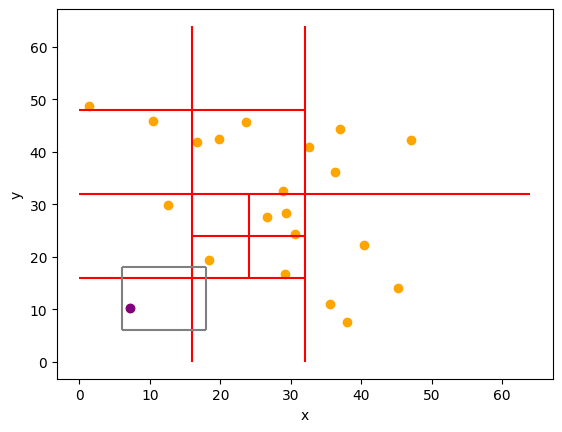

In [115]:
vis = Visualizer()
points = generate_random_points(21, 0, 50)
qtree = build_quadtree_vis(AABB((32, 32), 32, 32), points, vis)
q_range = AABB((12, 12), 6, 6)
vis.add_line_segment([
    [
        (6, 6),
        (6, 18)
    ],
    [
        (18, 6),
        (18, 18)
    ],
    [
        (6, 18),
        (18, 18)
    ],
    [
        (18, 6),
        (6, 6)
    ]
    
], color="grey")
q_out = qtree.query_range(q_range)
vis.add_point(q_out, color="purple")
vis.show()